<div style="text-align: right">   </div>





Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;

-------|-------------------

**Assignment 2 - Sequence processing using RNNs** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">







# Introduction





The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).



<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>



In this assignment you will be working with three different kinds of models, based on input/output data modalities:

1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation

2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.

3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.





### Description**

Let us suppose that we want to develop a neural network that learns how to add or subtract

two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or

’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a

sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,

we want to build a model that generalizes well - if the network can extract the underlying principles behind

the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate

valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),

2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.

The example above describes a text-to-text sequence mapping scenario. However, we can also use different

modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit

dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.



---



*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets



First we need to create our datasets that are going to be used for training our models.



In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

import cv2

import numpy as np

import tensorflow as tf

import random

from sklearn.model_selection import train_test_split



from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell

from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

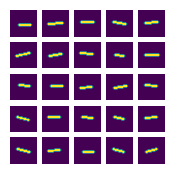

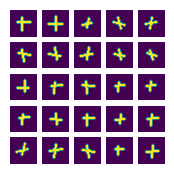

In [2]:
from scipy.ndimage import rotate





# Create plus/minus operand signs

def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)

    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates

    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates

    y2 = np.random.randint(18, 22, number_of_images)     # -||-



    for i in range(number_of_images): # Generate n different images

        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates

        if sign == '+':

            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates

        if sign == '*':

            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

            # Rotate 45 degrees

            blank_images[i] = rotate(blank_images[i], -50, reshape=False)

            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

            blank_images[i] = rotate(blank_images[i], -50, reshape=False)

            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)



    return blank_images



def show_generated(images, n=5):

    plt.figure(figsize=(2, 2))

    for i in range(n**2):

        plt.subplot(n, n, i+1)

        plt.axis('off')

        plt.imshow(images[i])

    plt.show()



show_generated(generate_images())

show_generated(generate_images(sign='+'))

In [5]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):

    """

    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:



    @return:

    X_text: '51+21' -> text query of an arithmetic operation (5)

    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28

    y_text: '72' -> answer of the arithmetic text query

    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)



    Images for digits are picked randomly from the whole MNIST dataset.

    """



    num_indices = [np.where(MNIST_labels==x) for x in range(10)]

    num_data = [MNIST_data[inds] for inds in num_indices]

    image_mapping = dict(zip(unique_characters[:10], num_data))

    image_mapping['-'] = generate_images()

    image_mapping['+'] = generate_images(sign='+')

    image_mapping['*'] = generate_images(sign='*')

    image_mapping[' '] = np.zeros([1, 28, 28])



    X_text, X_img, y_text, y_img = [], [], [], []



    for i in range(highest_integer + 1):      # First addend

        for j in range(highest_integer + 1):  # Second addend

            for sign in operands: # Create all possible combinations of operands

                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)

                query_image = []

                for n, char in enumerate(query_string):

                    image_set = image_mapping[char]

                    index = np.random.randint(0, len(image_set), 1)

                    query_image.append(image_set[index].squeeze())



                result = eval(query_string)

                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)

                result_image = []

                for n, char in enumerate(result_string):

                    image_set = image_mapping[char]

                    index = np.random.randint(0, len(image_set), 1)

                    result_image.append(image_set[index].squeeze())



                X_text.append(query_string)

                X_img.append(np.stack(query_image))

                y_text.append(result_string)

                y_img.append(np.stack(result_image))



    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.



def to_padded_chars(integer, max_len=3, pad_right=False):

    """

    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side

    """

    length = len(str(integer))

    padding = (max_len - length) * ' '

    if pad_right:

        return str(integer) + padding

    else:

        return padding + str(integer)


# Creating our data



The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:



  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]



  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]



  **y_text**: strings containing answers of length 3: ['  2', '156']



  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #2170

X_text: "10+85" = y_text: "95 "


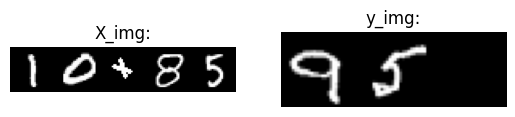

Query #4415

X_text: "22-7 " = y_text: "15 "


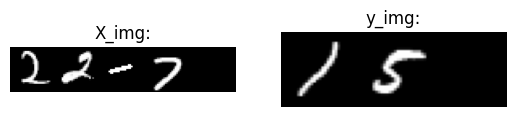

Query #6051

X_text: "30-25" = y_text: "5  "


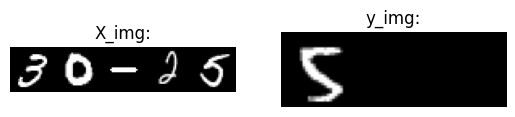

Query #791

X_text: "3-95 " = y_text: "-92"


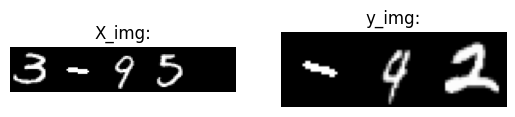

Query #3022

X_text: "15+11" = y_text: "26 "


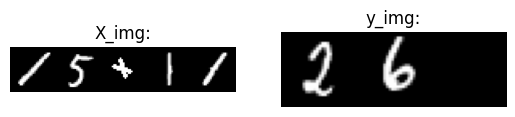

Query #8285

X_text: "41-42" = y_text: "-1 "


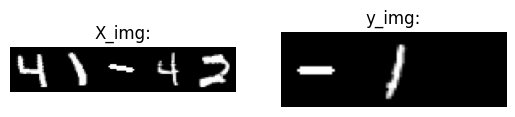

Query #3075

X_text: "15-37" = y_text: "-22"


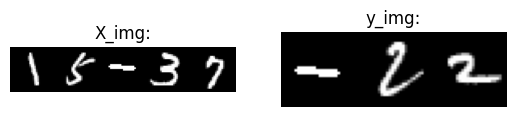

Query #6927

X_text: "34-63" = y_text: "-29"


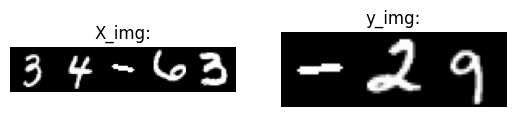

Query #9142

X_text: "45+71" = y_text: "116"


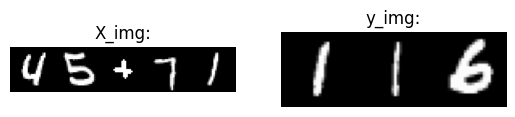

Query #1988

X_text: "9+94 " = y_text: "103"


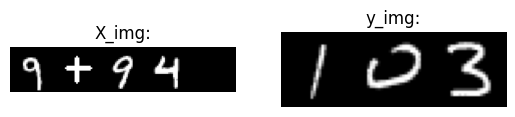

In [6]:
# Illustrate the generated query/answer pairs



unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)

highest_integer = 99                      # Highest value of integers contained in the queries



max_int_length = len(str(highest_integer))# Maximum number of characters in an integer

max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])

max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')



# Create the data (might take around a minute)

(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()

X_text, X_img, y_text, y_img = create_data(highest_integer)

print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)





## Display the samples that were created

def display_sample(n):

    labels = ['X_img:', 'y_img:']

    for i, data in enumerate([X_img, y_img]):

        plt.subplot(1,2,i+1)

        # plt.set_figheight(15)

        plt.axis('off')

        plt.title(labels[i])

        plt.imshow(np.hstack(data[n]), cmap='gray')

    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')

    plt.show()



for _ in range(10):

    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions



The functions below will help with input/output of the data.

In [7]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs

# You should use these functions to convert your strings and read out the output of your networks



def encode_labels(labels, max_len=3):
  
  n = len(labels)

  length = len(labels[0])

  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  
  one_hot = np.zeros([n, length, len(unique_characters)])
  
  for i, label in enumerate(labels):

      m = np.zeros([length, len(unique_characters)])

      for j, char in enumerate(label):

          m[j, char_map[char]] = 1
      
      one_hot[i] = m

  

  return one_hot





def decode_labels(labels):

    pred = np.argmax(labels, axis=1)
    
    predicted = ''.join([unique_characters[i] for i in pred])
    


    return predicted



X_text_onehot = encode_labels(X_text)

y_text_onehot = encode_labels(y_text)



print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,  y_test = train_test_split(X_text_onehot, y_text_onehot, test_size=0.10, random_state=42) 
X_train, X_valid,y_train,  y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=42) 


In [47]:

print(decode_labels(X_test[0]))
print(decode_labels(y_test[0]))


53+25
78 


---

---



## I. Text-to-text RNN model



The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:



1. LSTM

2. TimeDistributed

3. RepeatVector



The code cell below explains each of these new components.



<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [22]:
def build_text2text_model():



    # We start by initializing a sequential model

    text2text = tf.keras.Sequential()



    # "Encode" the input sequence using an RNN, producing an output of size 256.

    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,

    # as shown in the image above (except with 5 elements).

    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).

    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))



    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')

    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.

    text2text.add(RepeatVector(max_answer_length))



    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects

    # the first dimension to be the timesteps.

    text2text.add(LSTM(256, return_sequences=True))



    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.

    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))



    # Next we compile the model using categorical crossentropy as our loss function.

    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    text2text.summary()



    return text2text

In [32]:
## Your code (look at the assignment description for your tasks for text-to-text model):

##( Your first task is to fit the text2text model using X_text and y_text)
import keras
# Fit the model
model = build_text2text_model()
checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"text_to_text_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=10,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=50,
    callbacks = [checkpoint_cb, early_stopping]
)


model.save(f'submission1_text_to_text.keras')



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.3437 - loss: 1.9885 - val_accuracy: 0.4794 - val_loss: 1.4296
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.4916 - loss: 1.4015 - val_accuracy: 0.5317 - val_loss: 1.2890
Epoch 3/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.5583 - loss: 1.2073 - val_accuracy: 0.5963 - val_loss: 1.1253
Epoch 4/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.5932 - loss: 1.1070 - val_accuracy: 0.6113 - val_loss: 1.0500
Epoch 5/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6146 - loss: 1.0379 - val_accuracy: 0.6070 - val_loss: 1.0399
Epoch 6/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.6290 - loss: 0.9916 - val_accuracy: 0.6367 - val_loss: 0.9544
Epoch 7/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.6468 - loss: 0.9441 - val_accuracy: 0.6543 - val_loss: 0.9257
Epoch 8/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6589 - loss: 0.9149 - 

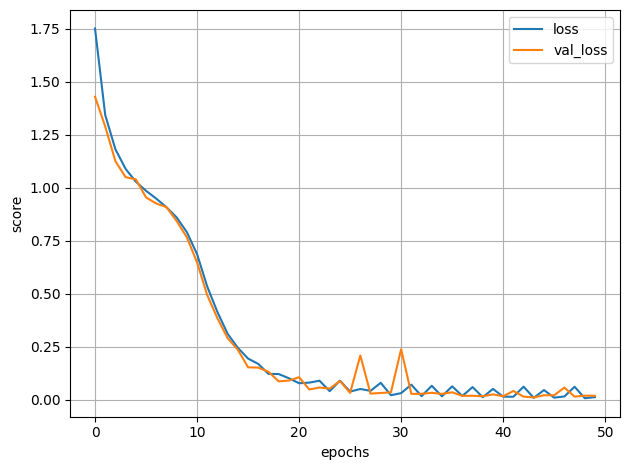

In [35]:
import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('text_to_text_history.csv')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
predictions = model.predict(X_test)
y_pred = [decode_labels(y) for y in predictions]
y_actual = [decode_labels(y) for y in y_test]

accuracy = accuracy_score(y_actual, y_pred)
print("Accuracy for text to text model:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy for text to text model: 0.994




---

---



## II. Image to text RNN Model



Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).



The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,  y_test = train_test_split(X_img, y_text_onehot, test_size=0.10, random_state=42) 
X_train, X_valid,y_train,  y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=42) 


78 


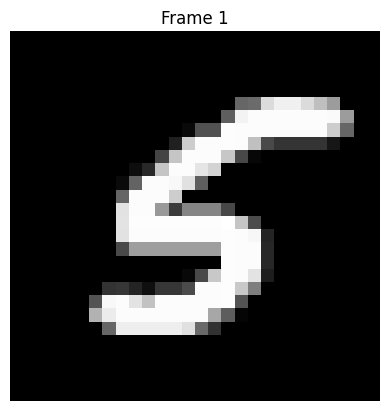

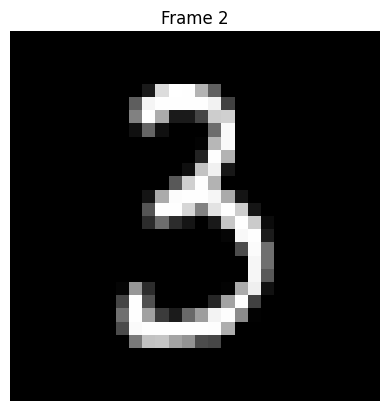

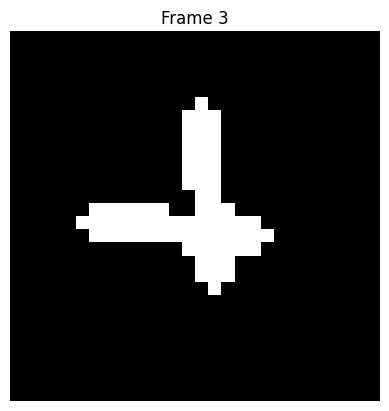

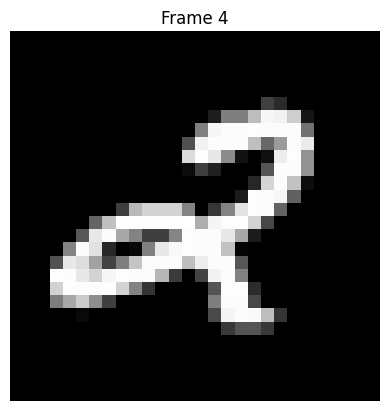

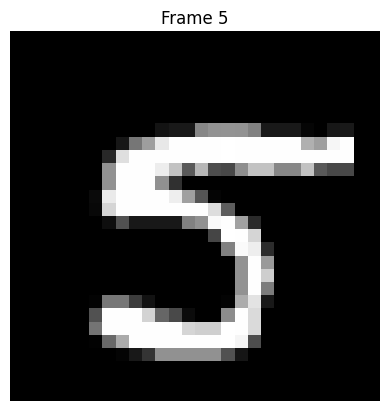

In [9]:
print(decode_labels(y_test[0]))

for i, frame in enumerate(X_test[0]):
    plt.imshow(frame, cmap='gray')  # Display the frame in grayscale
    plt.title(f"Frame {i + 1}")
    plt.axis("off")
    plt.show()

In [42]:
## Your code
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalAveragePooling1D,ConvLSTM2D,MaxPooling2D, BatchNormalization, Dropout,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
def build_img2text_model():



    # We start by initializing a sequential model

    img2text = tf.keras.Sequential()



    # "Encode" the input sequence using an RNN, producing an output of size 256.

    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,

    # as shown in the image above (except with 5 elements).

    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).

    img2text.add(ConvLSTM2D(filters=16,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu", input_shape=(5, 28, 28, 1), kernel_regularizer=l2(0.01)))

    img2text.add(BatchNormalization())

    img2text.add(Dropout(0.2))
    img2text.add(ConvLSTM2D(filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu", kernel_regularizer=l2(0.01)))

    img2text.add(BatchNormalization())

  
    #img2text.add(Flatten())
    img2text.add(TimeDistributed(GlobalAveragePooling2D()))
    img2text.add(Dense(256, activation='relu'))
    img2text.add(Dropout(0.2))
    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')

    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    img2text.add(GlobalAveragePooling1D())
    img2text.add(RepeatVector(max_answer_length))



    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects

    # the first dimension to be the timesteps.

    img2text.add(LSTM(128, return_sequences=True))
    img2text.add(LSTM(64, return_sequences=True))
    img2text.add(LayerNormalization())


    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax',kernel_regularizer=l2(0.01))))



    # Next we compile the model using categorical crossentropy as our loss function.
    
    optimizer = Adam(learning_rate=0.001) 
    img2text.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    img2text.summary()



    return img2text



def build_img2text_model2():

    img2text = tf.keras.Sequential()
    img2text.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu'), input_shape=(5, 28, 28, 1)))
    img2text.add(TimeDistributed(MaxPooling2D((2, 2))))
    img2text.add(TimeDistributed(Dropout(0.2)))
    img2text.add(TimeDistributed(Flatten()))
    img2text.add(TimeDistributed(Dense(200, activation='relu')))
    img2text.add(LSTM(256, return_sequences=True))
    img2text.add(LSTM(256))
    
    img2text.add(RepeatVector(max_answer_length))
    img2text.add(LSTM(256, return_sequences=True))
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    img2text.summary()

    return img2text
model = build_img2text_model2()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_31             │ (None, 5, 26, 26, 512) │         5,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 5, 13, 13, 512) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 5, 13, 13, 512) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 5, 86528)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_35             │ (None, 5, 200)         │    17,305,800 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 5, 256)         │       467,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_14 (RepeatVector) │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_36             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,832,853 (71.84 MB)

 Trainable params: 18,832,853 (71.84 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#to clear cache
import gc

# Delete unnecessary variables
del model

# Force garbage collection
gc.collect()


4951

Epoch 1/100


2024-11-23 20:53:22.007024: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_19_1/time_distributed_33_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 76s 36ms/step - accuracy: 0.3633 - loss: 1.9695 - val_accuracy: 0.4319 - val_loss: 1.6185 - learning_rate: 0.0010
Epoch 2/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0.4689 - loss: 1.4912 - val_accuracy: 0.5637 - val_loss: 1.2719 - learning_rate: 0.0010
Epoch 3/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0.5873 - loss: 1.1654 - val_accuracy: 0.6980 - val_loss: 0.9297 - learning_rate: 0.0010
Epoch 4/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0.7381 - loss: 0.7829 - val_accuracy: 0.7980 - val_loss: 0.6770 - learning_rate: 0.0010
Epoch 5/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0.8518 - loss: 0.5058 - val_accuracy: 0.8804 - val_loss: 0.4661 - learning_rate: 0.0010
Epoch 6/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.9015 - loss: 0.3690 - val_accuracy: 0.8959 - val_loss: 0.4127 - learning_rate: 0.0010
Epoch 7/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0

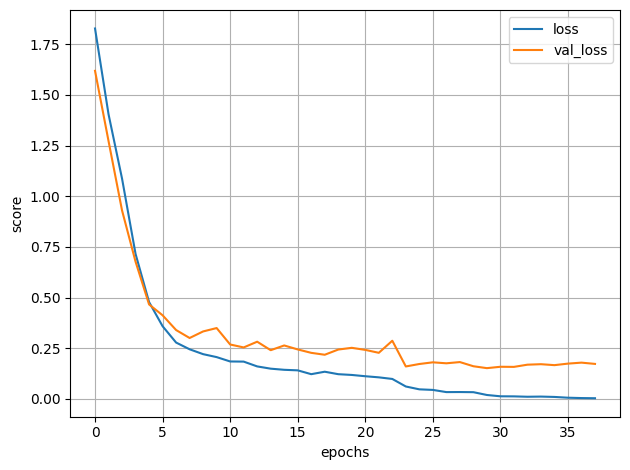

In [43]:

import keras
# Fit the model

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"image_to_text_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=8,
    epochs=100,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)


model.save(f'submission1_image_to_text.keras')

import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('image_to_text_history.csv')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
predictions = model.predict(X_test)
y_pred = [decode_labels(y) for y in predictions]
y_actual = [decode_labels(y) for y in y_test]

accuracy = accuracy_score(y_actual, y_pred)
print("Accuracy for image to text model:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Accuracy for image to text model: 0.9415


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalAveragePooling1D,ConvLSTM2D, BatchNormalization, Dropout,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

def build_img2text_withConv():
    ## Your code



    # We start by initializing a sequential model

    img2text = tf.keras.Sequential()



    # "Encode" the input sequence using an RNN, producing an output of size 256.

    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,

    # as shown in the image above (except with 5 elements).

    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).

    img2text.add(TimeDistributed(Conv2D(filters=512,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu", input_shape=(5, 28, 28, 1), kernel_regularizer=l2(0.01)))
    img2text.add(TimeDistributed(GlobalAveragePooling2D()))
    img2text.add(BatchNormalization())

    img2text.add(Dropout(0.2))
 

  
    #img2text.add(Flatten())
    
    img2text.add(Dense(256, activation='relu'))
    img2text.add(Dropout(0.2))
    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')

    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    img2text.add(GlobalAveragePooling1D())
    img2text.add(RepeatVector(max_answer_length))



    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects

    # the first dimension to be the timesteps.

    img2text.add(LSTM(128, return_sequences=True))
    img2text.add(LSTM(64, return_sequences=True))
    img2text.add(LayerNormalization())


    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax',kernel_regularizer=l2(0.01))))



    # Next we compile the model using categorical crossentropy as our loss function.
    
    optimizer = Adam(learning_rate=0.001) 
    img2text.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    img2text.summary()



    return img2text





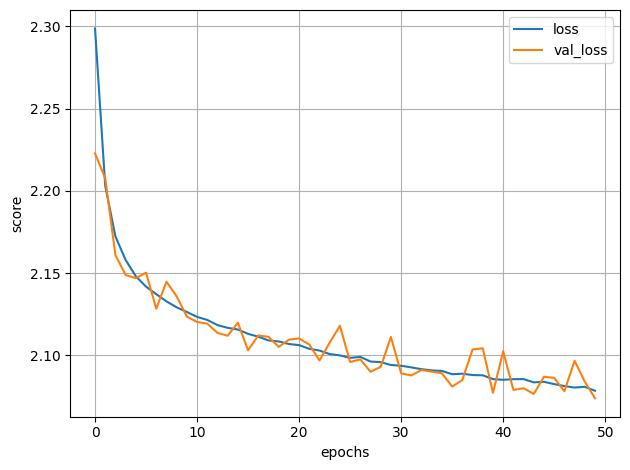

In [10]:
import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('image_to_text_history.csv')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()

---

---



## III. Text to image RNN Model



Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.



The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [ ]:
# Your code








